In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import iisignature
from scipy.optimize import minimize
from numba import jit
import matplotlib.pyplot as plt
import random
from scipy.stats import ks_2samp, wasserstein_distance
from scipy.stats import chi2

# Data

In [3]:
# period
start_date = "2010-01-01"
end_date = "2026-01-01"

# universe
tickers = {
    "S&P 500": "^GSPC",
    "DJIA": "^DJI",
    "Nasdaq": "^IXIC",
}

prices = yf.download(
    list(tickers.values()), start=start_date, end=end_date, 
    auto_adjust=False, progress=False)["Close"]

## 1 path each year

In [4]:
# build train paths
true_paths = [prices.loc[prices.index.year==i,"^GSPC"].values[:250] for i in range(2010,2025)]
true_paths_multi = [p/p[0] for p in true_paths] # normalized

ts_multi = np.linspace(0, 249, 250)
dt_true = (ts_multi[-1] - ts_multi[0]) / (len(ts_multi) - 1)
# detrend paths
true_paths_residuals_multi = []
trend_lines_multi = []
for path in true_paths_multi:
    trend_coeffs = np.polyfit(ts_multi, path, 1)
    trend = np.polyval(trend_coeffs, ts_multi)
    true_paths_residuals_multi.append(path - trend)
    trend_lines_multi.append(trend)
    
train_logs_multi = np.log(true_paths_multi)

## 1 path

In [5]:
# build train paths
true_paths = [prices.loc[prices.index.year<2025,"^GSPC"].values]
true_paths_one = [p/p[0] for p in true_paths] # normalized

ts_one = np.linspace(0, len(true_paths_one[0])-1, len(true_paths_one[0]))
dt_true = (ts_one[-1] - ts_one[0]) / (len(ts_one) - 1)
# detrend paths
true_paths_residuals_one = []
trend_lines_one = []
for path in true_paths_one:
    trend_coeffs = np.polyfit(ts_one, path, 1)
    trend = np.polyval(trend_coeffs, ts_one)
    true_paths_residuals_one.append(path - trend)
    trend_lines_one.append(trend)
    
train_logs_one = np.log(true_paths_one)

# Common functions

In [6]:
# paths: array of arrays of prices, ts: time index 1,2,3,4...
def get_path_signatures(ts, paths, window_size, sig_level, logsig):
    """
    Calculates signatures for all sliding windows of a collection of paths.
    """
    all_signatures = []
    for path in paths:
        current_ts = ts[:len(path)]
        path_2d = np.stack([current_ts, path], axis=1)
        for i in range(len(path) - window_size + 1):
            window = path_2d[i : i + window_size]
            if logsig == False:
                sig = iisignature.sig(window, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window, s)
            all_signatures.append(sig)
    return np.array(all_signatures)

def mmd_signature_linear(ts, paths1, paths2, window_size, sig_level):
    """
    Calculates the MMD between two collections of paths using the linear signature kernel.
    This is the squared Euclidean distance between the mean signatures.
    """
    sigs1 = get_path_signatures(ts, paths1, window_size, sig_level, False)
    sigs2 = get_path_signatures(ts, paths2, window_size, sig_level, False)

    if sigs1.shape[0] == 0 or sigs2.shape[0] == 0:
        return 0.0

    mean_sig1 = np.mean(sigs1, axis=0)
    mean_sig2 = np.mean(sigs2, axis=0)

    mmd_sq = np.sum((mean_sig1 - mean_sig2)**2)
    return mmd_sq

# Model 1: path-wise bootstrap

## Functions

In [7]:
def build_bootstrap_library_pathwise(ts, paths, lookback, sig_level, forward_window, logsig):
    """Builds the library of (signature, future_path_segment) pairs."""
    signatures_list, future_segments_list = [], []
    for path in paths:
        path_2d = np.stack([ts[:len(path)], path], axis=1)
        for i in range(lookback, len(path) - forward_window):
            window_2d = path_2d[i - lookback : i + 1]
            if logsig == False:
                sig = iisignature.sig(window_2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window_2d, s)
            start_val = path[i]
            '''here if path is log-return, then why do we need to minus start_val'''
            future_segment = path[i+1 : i + 1 + forward_window] - start_val   

            signatures_list.append(sig)
            future_segments_list.append(future_segment)
    return np.array(signatures_list), np.array(future_segments_list)

# K-NN part. seed_path: pregiven path start longer than lookback, n_tot_step: len of the wholde path want
def generate_path_bootstrap_pathwise(seed_path, n_total_steps, lookback, sig_level, dt, library_sigs, library_segments, logsig, k, SEED):
    """Generates a full path by appending historical path segments."""
    gen_path_list = list(seed_path)
    forward_window = library_segments.shape[1]

    while len(gen_path_list) < n_total_steps:
        current_lookback_path = np.array(gen_path_list[-(lookback+1):])
        time_segment = np.arange(len(current_lookback_path)) * dt
        current_window = np.stack([time_segment, current_lookback_path], axis=1)
        if logsig == False:
                query_sig = iisignature.sig(current_window, sig_level)
        else:
            s = iisignature.prepare(2, sig_level, 'S')
            query_sig = iisignature.logsig(current_window, s)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        if SEED:
            rng = np.random.default_rng(SEED)
            chosen_neighbor_idx = rng.choice(neighbor_indices)
        else:
            chosen_neighbor_idx = np.random.choice(neighbor_indices)
        chosen_segment = library_segments[chosen_neighbor_idx]
        next_segment = gen_path_list[-1] + chosen_segment
        gen_path_list.extend(list(next_segment))

    return np.array(gen_path_list)[:n_total_steps]

## Train (year by year)

In [8]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
k = 10
SEED = 1234


# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,False)

all_bootstrap_paths_multi = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, False, k,SEED)
    all_bootstrap_paths_multi.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.018412


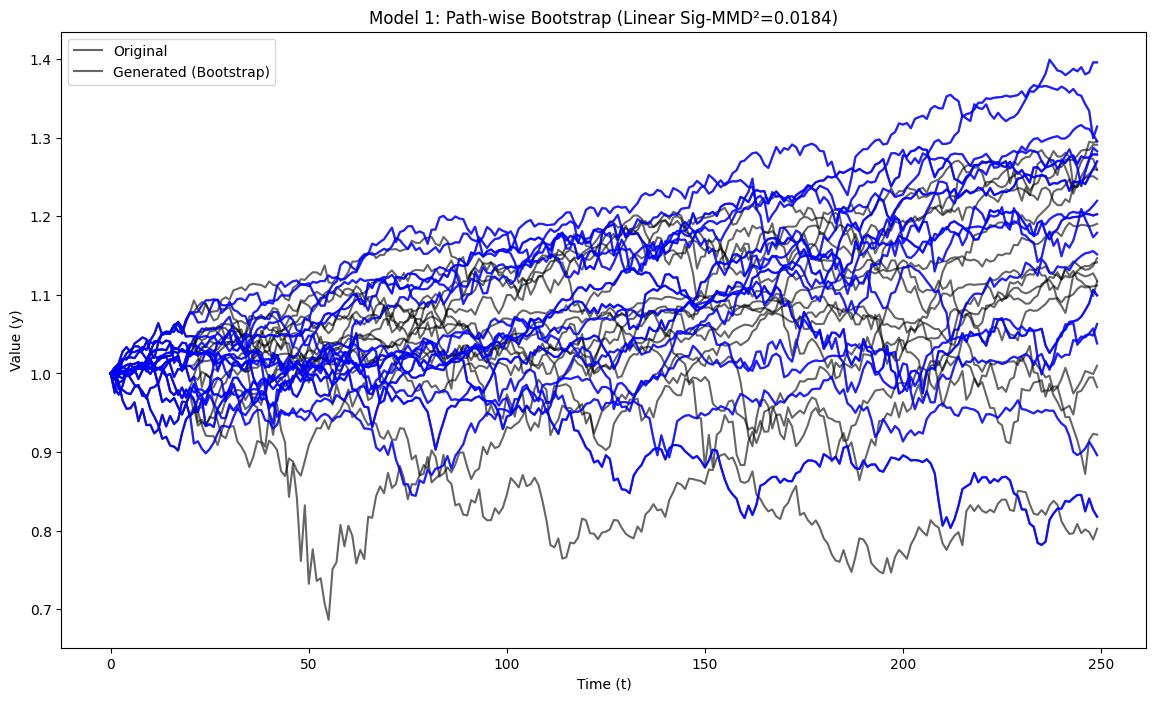

In [9]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 1: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train (1 path)

In [10]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
k = 10
SEED = None

# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW, False)

all_bootstrap_paths_one = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, False, k,SEED)
    all_bootstrap_paths_one.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_one, true_paths_one, all_bootstrap_paths_one, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.029113


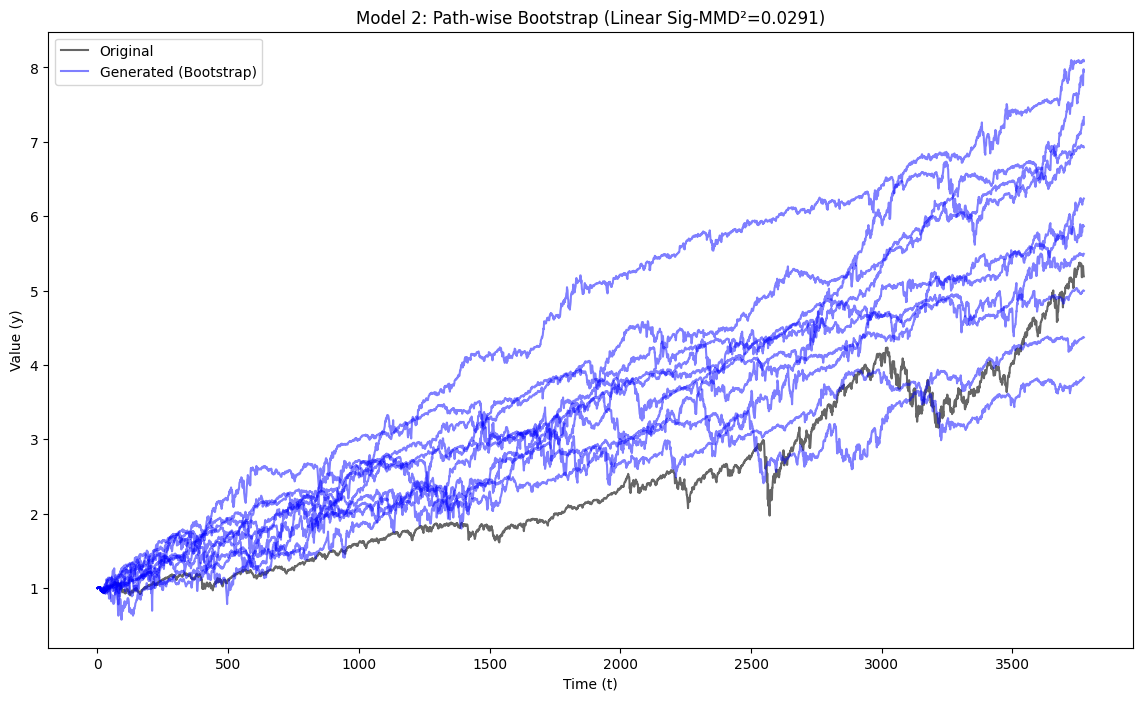

In [11]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_one:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train year by year on logsig

In [12]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
k = 10
SEED = 1234
logsig = True

# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,logsig)

all_bootstrap_paths_multi_log = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments, logsig, k, SEED)
    all_bootstrap_paths_multi_log.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_multi, true_paths_multi, all_bootstrap_paths_multi_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.028589


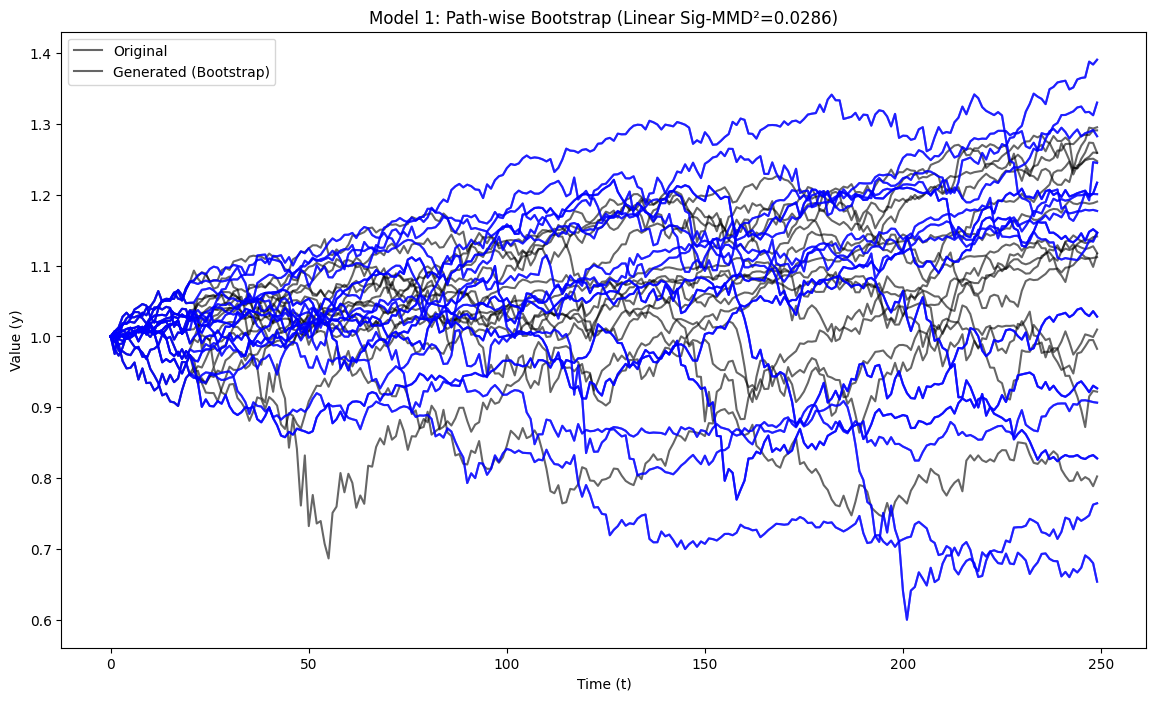

In [13]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_multi_log:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 1: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Trian 1 path with logsig

In [14]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
k = 10
SEED = None

# given detrend paths data: true_paths_residuals
bootstrap_library_sigs, bootstrap_library_segments = build_bootstrap_library_pathwise(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, BOOTSTRAP_FORWARD_WINDOW,logsig)

all_bootstrap_paths_one_log = []
for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS] 
    # Generate residual paths and add the trend back
    bootstrap_residuals_gen = generate_path_bootstrap_pathwise(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, bootstrap_library_sigs, bootstrap_library_segments,logsig, k, SEED)
    all_bootstrap_paths_one_log.append(bootstrap_residuals_gen + trend_to_add)
    
# Evaluate
MMD_WINDOW_SIZE = 15
mmd_bootstrap = mmd_signature_linear(ts_one, true_paths_one, all_bootstrap_paths_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Path-wise Bootstrap):   {mmd_bootstrap:.6f}")

   - Linear Sig-MMD^2 (Path-wise Bootstrap):   0.024287


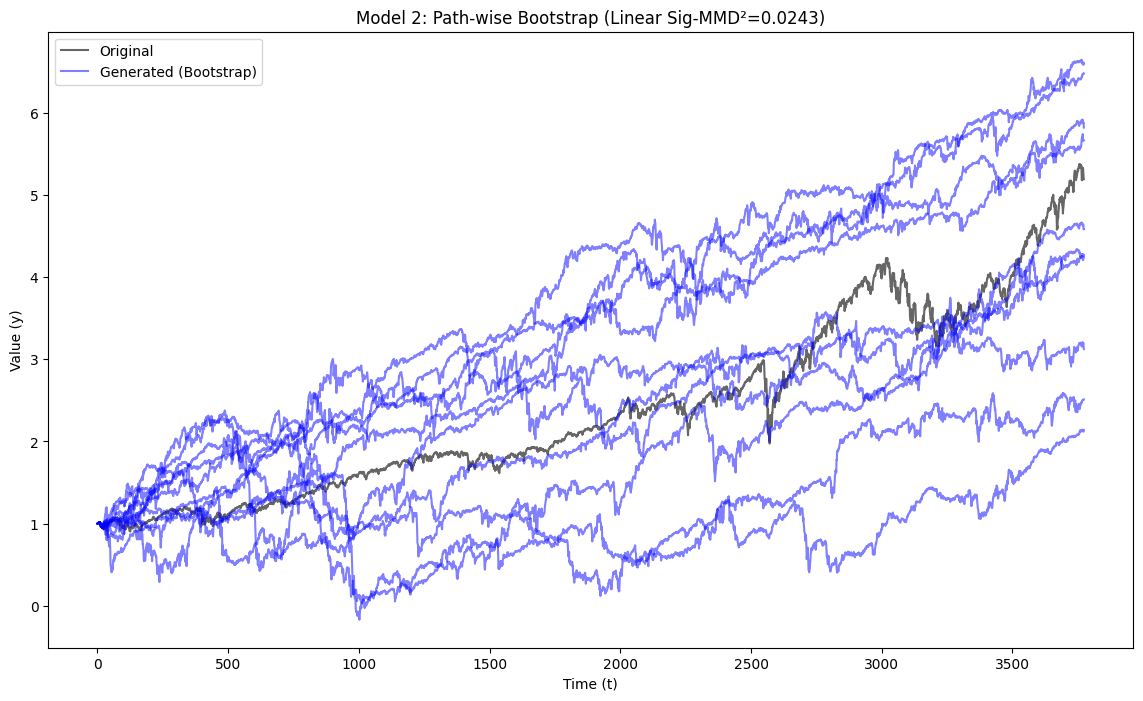

In [15]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
for p in all_bootstrap_paths_one_log:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Path-wise Bootstrap (Linear Sig-MMD²={mmd_bootstrap:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

# Model 2: hybrid SDE

## Function

In [17]:
@jit(nopython=True)
def get_mu_model(params, y):
    """Calculates drift: mu(y) = c*y. A simple mean-reverting model."""
    c = params[0]
    return c * y

@jit(nopython=True)
def loss_function_numba(params, dS, y_levels, dt, reg_strength):
    """Numba-accelerated loss function for the simple mean-reverting drift model."""
    params_mu = params
    mu_t = np.empty(len(y_levels))
    for i in range(len(y_levels)):
        y = y_levels[i]
        mu_t[i] = get_mu_model(params_mu, y)

    residuals = dS - mu_t * dt
    loss = np.sum(residuals**2) + reg_strength * np.sum(params**2)
    return loss

def loss_function_wrapper(params, dS, y_levels, dt, reg_strength):
    return loss_function_numba(params, dS, y_levels, dt, reg_strength)

# here the forward save the de-predicted trend residual (just one step each time)
def build_hybrid_library(ts, paths, lookback, sig_level, params_mu, dt, logsig):
    """Builds a library of (signature, residual) pairs for the hybrid model."""
    signatures_list, residuals_list = [], []
    for path in paths:
        path_2d = np.stack([ts[:len(path)], path], axis=1)
        dS_path = np.diff(path)
        for i in range(lookback, len(path) - 1):
            window_2d = path_2d[i - lookback : i + 1]
            if logsig == False:
                sig = iisignature.sig(window_2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(window_2d, s)
            y_i = path[i]
            predicted_drift = get_mu_model(params_mu, y_i) * dt
            actual_increment = dS_path[i]
            residual = actual_increment - predicted_drift

            signatures_list.append(sig)
            residuals_list.append(residual)

    return np.array(signatures_list), np.array(residuals_list)

def generate_path_hybrid(seed_path, n_total_steps, lookback, sig_level, dt, params_mu, library_sigs, library_residuals, logsig, k, SEED):
    """Generates a path using the hybrid SDE-bootstrap method."""
    gen_path_list = list(seed_path)
    for i in range(n_total_steps - len(seed_path)):
        current_y = gen_path_list[-1]
        predicted_drift = get_mu_model(params_mu, current_y) * dt

        current_lookback_path = np.array(gen_path_list[-(lookback+1):])
        time_segment = np.arange(len(current_lookback_path)) * dt
        current_window = np.stack([time_segment, current_lookback_path], axis=1)
        query_sig = iisignature.sig(current_window, sig_level)
        if logsig == False:
            query_sig = iisignature.sig(current_window, sig_level)
        else:
            s = iisignature.prepare(2, sig_level, 'S')
            query_sig = iisignature.logsig(current_window, s)
        distances = np.linalg.norm(library_sigs - query_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]
        if SEED:
            rng = np.random.default_rng(SEED)
            chosen_neighbor_idx = rng.choice(neighbor_indices)
        else:
            chosen_neighbor_idx = np.random.choice(neighbor_indices)

        sampled_residual = library_residuals[chosen_neighbor_idx]
        next_val = current_y + predicted_drift + sampled_residual
        gen_path_list.append(next_val)

    return np.array(gen_path_list)

## Train (year by year)

In [18]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
REG_STRENGTH = 1.0
k = 10
SEED = 1234
logsig = False
    
# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_multi:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_multi = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, params_mu_opt_multi, dt_true, logsig)

all_hybrid_paths_multi = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_multi, hybrid_library_sigs, hybrid_library_residuals,logsig, k, SEED)
    all_hybrid_paths_multi.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_multi, true_paths_multi, all_hybrid_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.000867


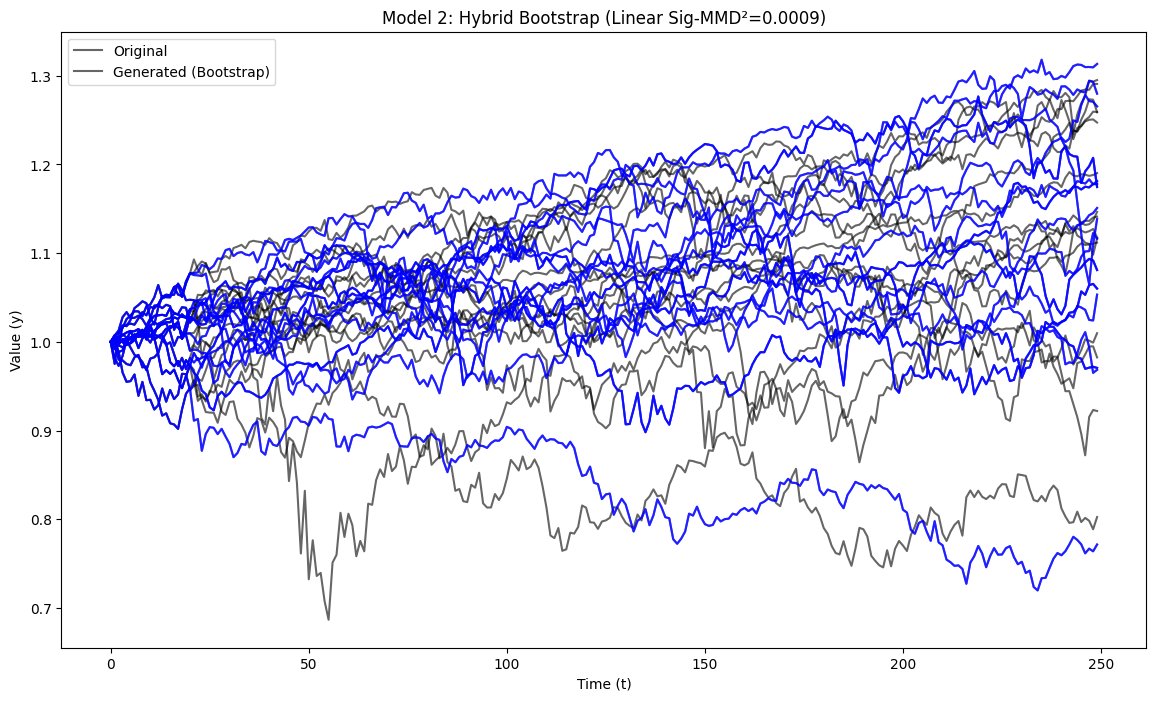

In [19]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_hybrid_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train (1 path)

In [20]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
REG_STRENGTH = 1.0
k = 10
logsig = False
SEED = None

# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_one:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_one = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, params_mu_opt_one, dt_true, logsig)

all_hybrid_paths_one = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_one, hybrid_library_sigs, hybrid_library_residuals, logsig, k, SEED)
    all_hybrid_paths_one.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_one, true_paths_one, all_hybrid_paths_one, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.052511


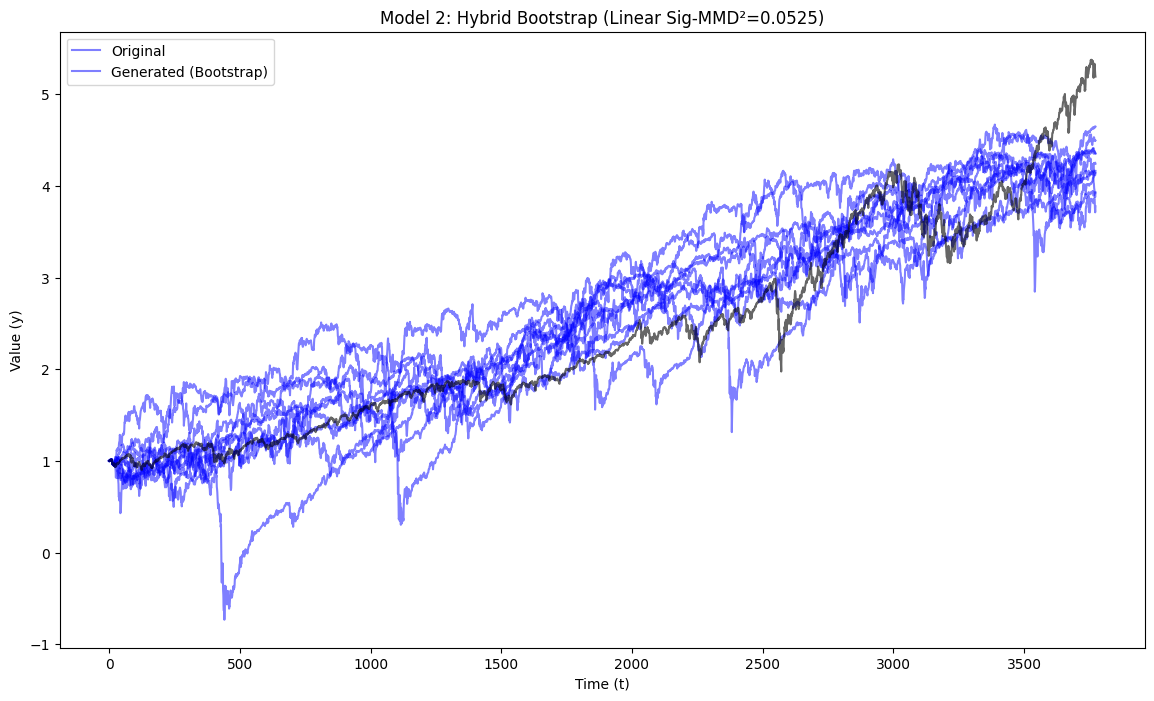

In [21]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for p in all_hybrid_paths_one:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train year by year with logsig

In [22]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 50
T_SIZE = len(true_paths_multi[0])
N_GROUND_TRUTH_PATHS = len(true_paths_multi)
REG_STRENGTH = 1.0
k = 10
logsig = True
SEED = 1234

# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_multi:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_multi_log = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_multi, true_paths_residuals_multi, LOOKBACK, SIG_LEVEL, params_mu_opt_multi_log, dt_true,logsig)

all_hybrid_paths_multi_log = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_multi[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_multi[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_multi_log, hybrid_library_sigs, hybrid_library_residuals, logsig, k, SEED)
    all_hybrid_paths_multi_log.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_multi, true_paths_multi, all_hybrid_paths_multi_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.004026


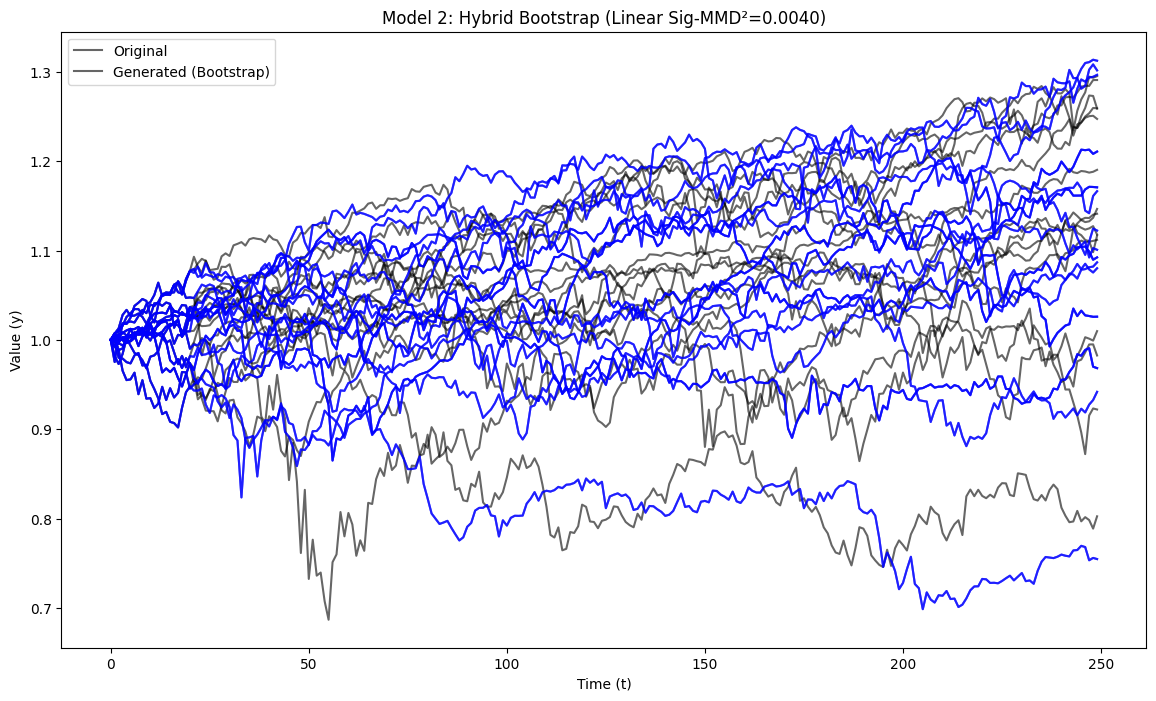

In [23]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_hybrid_paths_multi_log:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

## Train 1 year with logsig

In [24]:
LOOKBACK = 20
SIG_LEVEL = 3
BOOTSTRAP_FORWARD_WINDOW = 5
N_PATHS_TO_GENERATE = 10
T_SIZE = len(true_paths_one[0])
N_GROUND_TRUTH_PATHS = len(true_paths_one)
REG_STRENGTH = 1.0
logsig= True
SEED = None
k = 10

# Train the drift model on the de-trended residuals
all_dS_residuals, all_y_levels_residuals = [], []
for path in true_paths_residuals_one:
    dS_path = np.diff(path)
    for i in range(LOOKBACK, len(path) - 1):
        all_dS_residuals.append(dS_path[i])
        all_y_levels_residuals.append(path[i])

dS_full_aligned = np.array(all_dS_residuals)
y_levels_full = np.array(all_y_levels_residuals)

mu_param_count = 1
initial_params = np.array([-0.1])

res = minimize(loss_function_wrapper, initial_params,
               args=(dS_full_aligned, y_levels_full, dt_true, REG_STRENGTH),
               method='L-BFGS-B', options={'maxiter': 500})

params_mu_opt_one_log = res.x

hybrid_library_sigs, hybrid_library_residuals = build_hybrid_library(ts_one, true_paths_residuals_one, LOOKBACK, SIG_LEVEL, params_mu_opt_one_log, dt_true,logsig)

all_hybrid_paths_one_log = []

for i in range(N_PATHS_TO_GENERATE):
    # Use a consistent seed path from the de-trended data
    seed_path_residuals = true_paths_residuals_one[i % N_GROUND_TRUTH_PATHS][:LOOKBACK+1]
    trend_to_add = trend_lines_one[i % N_GROUND_TRUTH_PATHS]
    # Generate residual paths and add the trend back
    hybrid_residuals_gen = generate_path_hybrid(seed_path_residuals, T_SIZE, LOOKBACK, SIG_LEVEL, dt_true, params_mu_opt_one_log, hybrid_library_sigs, hybrid_library_residuals,logsig, k, SEED)
    all_hybrid_paths_one_log.append(hybrid_residuals_gen + trend_to_add)

# Evaluate
MMD_WINDOW_SIZE = 15
mmd_hybrid = mmd_signature_linear(ts_one, true_paths_one, all_hybrid_paths_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (Hybrid SDE Model):      {mmd_hybrid:.6f}")

   - Linear Sig-MMD^2 (Hybrid SDE Model):      0.055712


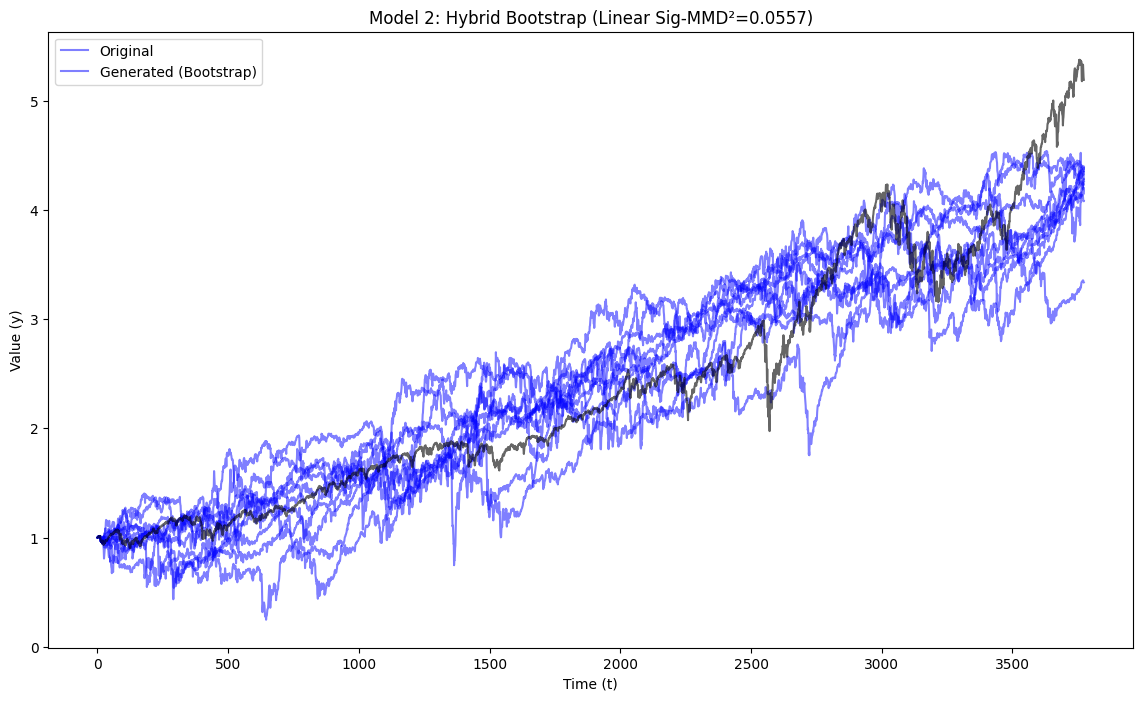

In [25]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for p in all_hybrid_paths_one_log:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
ax1_boot.set_title(f'Model 2: Hybrid Bootstrap (Linear Sig-MMD²={mmd_hybrid:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (Bootstrap)'])

# Model 3: KRR model

## Function

In [26]:
def build_dataset(log_paths, lookback, sig_level, dt, logsig):
    S_list, y_mu, y_logsig = [], [], []
    for log_s in log_paths:
        n_steps = len(log_s)-1
        for i in range(lookback, n_steps):
            window = log_s[i-lookback:i+1]
            times  = np.linspace(0, lookback*dt, lookback+1)
            path2d = np.stack([times, window], axis=1)
            if logsig == False:
                sig = iisignature.sig(path2d, sig_level)
            else:
                s = iisignature.prepare(2, sig_level, 'S')
                sig = iisignature.logsig(path2d, s)
            S_list.append(sig)
            # drift target
            dlog = log_s[i+1] - log_s[i]
            y_mu.append(dlog/dt)
            # vol target
            past_rets = np.diff(window)
            sigma_est = np.std(past_rets) / np.sqrt(dt)
            y_logsig.append(np.log(sigma_est + 1e-8))
    S  = np.vstack(S_list)
    ym = np.array(y_mu)[:, None]
    ys = np.array(y_logsig)[:, None]
    return S, ym, ys

### KRR ###
def train_kernel_ridge(S, y, lam):
    # (K + lam I) alpha = y
    K = S @ S.T
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), y)
    return alpha, S

def predict(alpha, S_train, sig_new):
    k = S_train @ sig_new
    return (k @ alpha).item()

## Train (year by year)

In [27]:
T, N_STEPS = 1, len(train_logs_multi[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 15, 50
LAMBDA = 2.0
dt = T / N_STEPS
logsig = False
S_train, y_mu, y_logsig = build_dataset(train_logs_multi, LOOKBACK, SIG_LEVEL, dt,logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_multi = []
# use first training path as seed for all generations
seed = train_logs_multi[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    rng = np.random.default_rng(SEED)
    seed_path = random.choice(train_logs_multi)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_multi.append(log_gen)

all_krr_paths_multi = np.exp(gen_logs_multi)
# Evaluate
MMD_WINDOW_SIZE = 15
SIG_LEVEL = 3
mmd_krr = mmd_signature_linear(ts_multi, true_paths_multi, all_krr_paths_multi, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (KRR SDE Model):      {mmd_krr:.6f}")

Dataset: 3585 samples, 30 features
Training kernel ridge for drift and log-vol...
Generating 50 new paths with random seeding...
   - Linear Sig-MMD^2 (KRR SDE Model):      0.004088


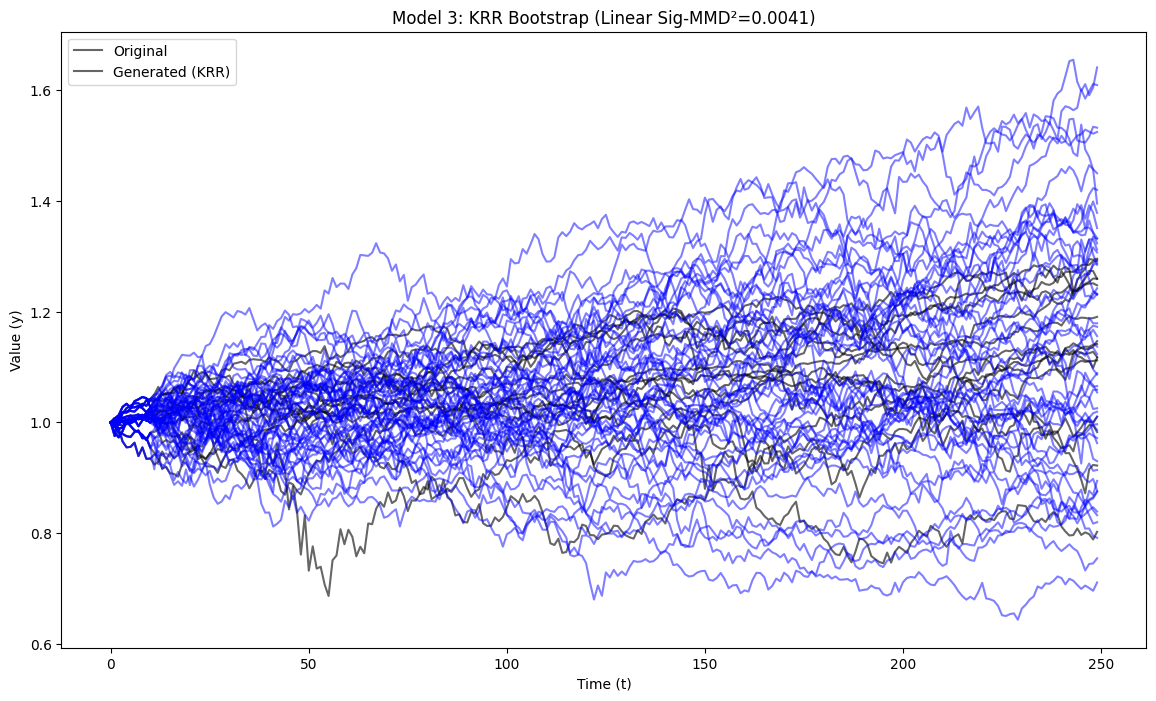

In [28]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_krr_paths_multi:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 3: KRR Bootstrap (Linear Sig-MMD²={mmd_krr:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (KRR)'])

## Train (1 path)

In [29]:
T, N_STEPS = 1, len(train_logs_one[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 1, 15
LAMBDA = 2.0
logsig = False
dt = T / N_STEPS

S_train, y_mu, y_logsig = build_dataset(train_logs_one, LOOKBACK, SIG_LEVEL, dt, logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_one = []
# use first training path as seed for all generations
seed = train_logs_one[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    seed_path = random.choice(train_logs_one)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        # clip for noshock
        ls_pred = np.clip(ls_pred, np.percentile(y_logsig, 1), np.percentile(y_logsig, 99))
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_one.append(log_gen)

all_krr_paths_one = np.exp(gen_logs_one)
# Evaluate
MMD_WINDOW_SIZE = 15
SIG_LEVEL = 3
mmd_krr = mmd_signature_linear(ts_one, true_paths_one, all_krr_paths_one, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (KRR SDE Model):      {mmd_krr:.6f}")

Dataset: 3763 samples, 30 features
Training kernel ridge for drift and log-vol...
Generating 15 new paths with random seeding...
   - Linear Sig-MMD^2 (KRR SDE Model):      0.382780


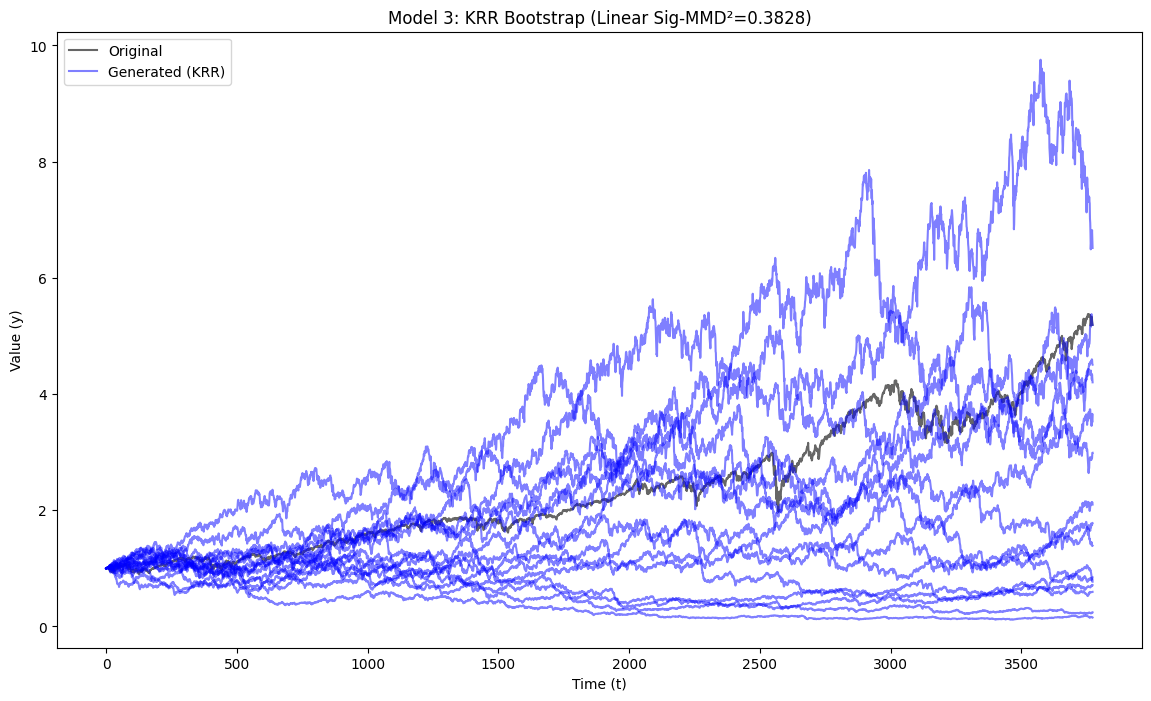

In [30]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
for p in all_krr_paths_one:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 3: KRR Bootstrap (Linear Sig-MMD²={mmd_krr:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (KRR)'])

## Train year by year with logsig

In [31]:
T, N_STEPS = 1, len(train_logs_multi[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 15, 50
logsig = True
LAMBDA = 2.0

dt = T / N_STEPS

S_train, y_mu, y_logsig = build_dataset(train_logs_multi, LOOKBACK, SIG_LEVEL, dt,logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_multi_log = []
# use first training path as seed for all generations
seed = train_logs_multi[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    seed_path = random.choice(train_logs_multi)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        #sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        s = iisignature.prepare(2, SIG_LEVEL, 'S')
        sig_new = iisignature.logsig(np.stack([times, window],1), s)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_multi_log.append(log_gen)

all_krr_paths_multi_log = np.exp(gen_logs_multi_log)
# Evaluate
MMD_WINDOW_SIZE = 15
SIG_LEVEL = 3
mmd_krr = mmd_signature_linear(ts_multi, true_paths_multi, all_krr_paths_multi_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (KRR SDE Model):      {mmd_krr:.6f}")

Dataset: 3585 samples, 8 features
Training kernel ridge for drift and log-vol...
Generating 50 new paths with random seeding...
   - Linear Sig-MMD^2 (KRR SDE Model):      0.000223


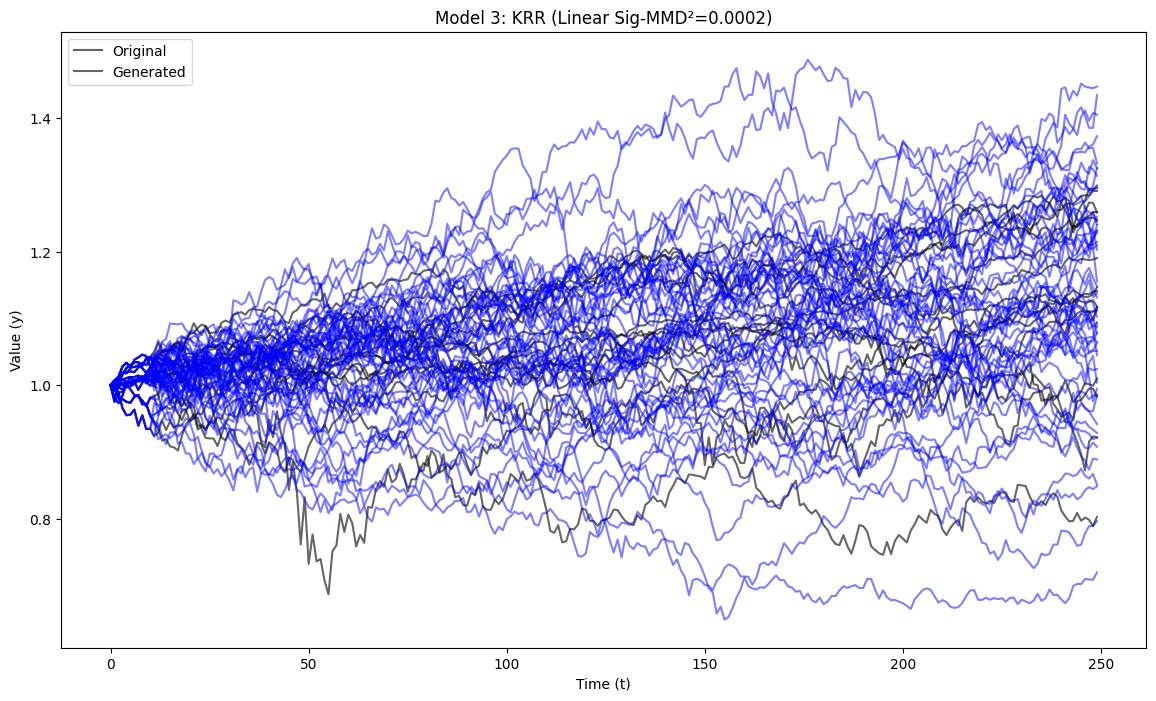

In [32]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_multi:
    ax1_boot.plot(ts_multi, path, color='black', alpha=0.6)
for p in all_krr_paths_multi_log:
    ax1_boot.plot(ts_multi[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 3: KRR (Linear Sig-MMD²={mmd_krr:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated'])

In [33]:
T, N_STEPS = 1, len(train_logs_one[0])-1
LOOKBACK, SIG_LEVEL = 10, 4
N_PATHS, N_GEN = 1, 15
LAMBDA = 2.0
logsig = True
dt = T / N_STEPS

S_train, y_mu, y_logsig = build_dataset(train_logs_one, LOOKBACK, SIG_LEVEL, dt, logsig)
print(f"Dataset: {S_train.shape[0]} samples, {S_train.shape[1]} features")

# 3. Train kernel ridge models
print("Training kernel ridge for drift and log-vol...")
alpha_mu, S_mu = train_kernel_ridge(S_train, y_mu, LAMBDA)
alpha_ls, S_ls = train_kernel_ridge(S_train, y_logsig, LAMBDA)

# 4. Generate new paths
print(f"Generating {N_GEN} new paths with random seeding...")
gen_logs_one_log = []
# use first training path as seed for all generations
seed = train_logs_one[0][:LOOKBACK+1]
for _ in range(N_GEN):
    # RANDOMLY SAMPLE A SEED FOR EACH NEW PATH
    seed_path = random.choice(train_logs_one)
    seed_segment = seed_path[:LOOKBACK+1]

    log_gen = np.zeros(N_STEPS+1)
    log_gen[:LOOKBACK+1] = seed_segment

    for i in range(LOOKBACK, N_STEPS):
        window = log_gen[i-LOOKBACK:i+1]
        times  = np.linspace(0, LOOKBACK*dt, LOOKBACK+1)
        #sig_new = iisignature.sig(np.stack([times, window],1), SIG_LEVEL)
        s = iisignature.prepare(2, SIG_LEVEL, 'S')
        sig_new = iisignature.logsig(np.stack([times, window],1), s)
        mu_pred = predict(alpha_mu, S_mu, sig_new)
        ls_pred = predict(alpha_ls, S_ls, sig_new)
        # clip for noshock
        ls_pred = np.clip(ls_pred, np.percentile(y_logsig, 1), np.percentile(y_logsig, 99))
        sigma_pred = np.exp(ls_pred)
        dW = np.random.randn() * np.sqrt(dt)
        log_gen[i+1] = log_gen[i] + mu_pred*dt + sigma_pred*dW
    gen_logs_one_log.append(log_gen)

all_krr_paths_one_log = np.exp(gen_logs_one_log)
# Evaluate
SIG_LEVEL = 3
MMD_WINDOW_SIZE = 15
mmd_krr = mmd_signature_linear(ts_one, true_paths_one, all_krr_paths_one_log, MMD_WINDOW_SIZE, SIG_LEVEL)
print(f"   - Linear Sig-MMD^2 (KRR Model):      {mmd_krr:.6f}")

Dataset: 3763 samples, 8 features
Training kernel ridge for drift and log-vol...
Generating 15 new paths with random seeding...
   - Linear Sig-MMD^2 (KRR Model):      0.531072


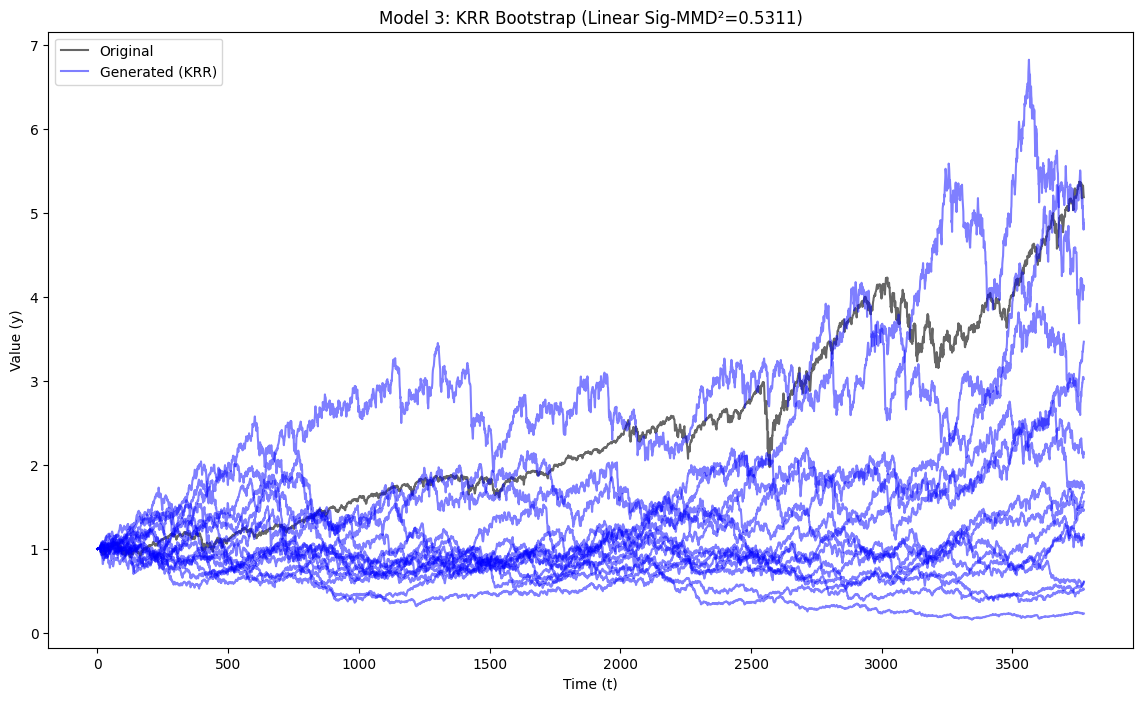

In [34]:
fig2, ax1_boot = plt.subplots(figsize=(14, 8))
for path in true_paths_one:
    ax1_boot.plot(ts_one, path, color='black', alpha=0.6)
for p in all_krr_paths_one_log:
    ax1_boot.plot(ts_one[:len(p)], p, color='blue', alpha=0.5)
ax1_boot.set_title(f'Model 3: KRR Bootstrap (Linear Sig-MMD²={mmd_krr:.4f})')
ax1_boot.set_xlabel('Time (t)')
ax1_boot.set_ylabel('Value (y)')
ax1_boot.legend(['Original', 'Generated (KRR)'])